In [14]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn
from torch import optim
from torchvision import transforms

from tqdm import tqdm
from PIL import Image
import librosa
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt

%matplotlib inline 


In [15]:
FILE_PATH = "/mnt/c/Users/86181/Datasets/Bird"
BIRD_LABEL = {
    "0009": "灰雁",
    "0017": "大天鹅",
    "0034": "绿头鸭",
    "0036": "绿翅鸭",
    "0074": "灰山鹑",
    "0077": "西鹌鹑",
    "0114": "雉鸡",
    "0121": "红喉潜鸟",
    "0180": "苍鹭",
    "0202": "普通鸬鹚",
    "0235": "苍鹰",
    "0257": "欧亚鵟",
    "0265": "西方秧鸡",
    "0281": "骨顶鸡",
    "0298": "黑翅长脚鹬",
    "0300": "凤头麦鸡",
    "0364": "白腰草鹬",
    "0368": "红脚鹬",
    "0370": "林鹬",
    "1331": "麻雀"
}
TRAIN_RATIO = 0.8
VALIDATE_RATIO = 0.2

warnings.filterwarnings('ignore')
torch.set_default_tensor_type(torch.FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# super parameters
batch_size = 50
lr = 0.001
epoch = 50
max_count = 200
full_data = False

In [17]:
def convert_to_mfcc(wav_file):
    y, sr = librosa.load(wav_file,sr=None)
    # spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(spectrogram, ref=np.max) # use positive value!
    mfcc = librosa.feature.mfcc(S=S_dB,sr=None,n_mfcc=40,dct_type=2)
    mfcc = Image.fromarray(mfcc)
    return mfcc

In [18]:
def load_files():
    label = []
    wav_data = []
    # eye = np.eye(20)

    # get filenames
    for index, dir in enumerate(BIRD_LABEL.keys()):
        wav_files = os.listdir(FILE_PATH + '/' + dir)

        if(full_data == False):
            wav_files = wav_files[0:max_count]

        print("checking {}".format(dir))
        for wav_file in tqdm(wav_files):
            filename = FILE_PATH + '/' + dir + '/' + wav_file
            wav = convert_to_mfcc(filename)
            wav_data.append(wav)
            label.append(index)

    print('done')

    # shuffle
    state = np.random.get_state()
    np.random.shuffle(wav_data)
    np.random.set_state(state)
    np.random.shuffle(label)

    # divide
    length = len(label)
    train_index = int(length*TRAIN_RATIO)

    train_data = wav_data[0:train_index]
    train_label = label[0:train_index]
    validate_data = wav_data[train_index:]
    validate_label = label[train_index:]

    return train_data,train_label,validate_data,validate_label


In [19]:
class SoundDataSet(Dataset):
    def __init__(self,data_list,label_list,transform):
        self.transform = transform
        self.wav_data = data_list
        self.label = label_list

    def __getitem__(self, index):
        wav = self.wav_data[index]
        wav = self.transform(wav)
        label = self.label[index]
        return wav, label

    def __len__(self):
        return len(self.wav_data)

In [20]:
def get_loader():
    
    train_data,train_label,validate_data,validate_label = load_files()

    transform = transforms.Compose([
        # transforms.Resize((50,50)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5,std=0.5)
    ])

    # build dataset
    train_dataset = SoundDataSet(train_data,train_label,transform)
    validate_dataset = SoundDataSet(validate_data,validate_label,transform)

    # build dataloader
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=1)

    validate_loader = DataLoader(dataset=validate_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=1)

    return train_loader,validate_loader




In [21]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=(3, 3),
                               stride=(1, 1),
                               padding=0)

        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=(3, 3),
                               stride=(1, 1),
                               padding=0)

        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=(3, 3),
                               stride=(1, 1),
                               padding=0)

        self.conv4 = nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=(3, 3),
                               stride=(1, 1),
                               padding=0)

        self.batchNorm1 = nn.BatchNorm2d(32)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.batchNorm3 = nn.BatchNorm2d(256)
        self.relu = nn.LeakyReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.linear1 = nn.Linear(in_features=256, out_features=32)
        self.linear2 = nn.Linear(in_features=32, out_features=20)

    def forward(self,x):
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv3(x)
        # x = self.batchNorm3(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout1(x)

        x = self.conv4(x)
        # x = self.batchNorm4(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout1(x)

        x = x.view(x.shape[0], -1) # 将数据设置为1维
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x

In [22]:
def get_network():
    cnn = CNN()
    optimizer = optim.Adam(cnn.parameters(),
                           lr = lr,
                           betas = (0.9, 0.999),
                           eps = 1e-8,
                           weight_decay = 0)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10,eta_min=0.002)
    loss = nn.CrossEntropyLoss()
    cnn = cnn.to(device = device)
    return cnn, optimizer, loss,scheduler

In [23]:
# load data
x = np.arange(1, epoch + 1, 1)
train_loader, validate_loader = get_loader()
cnn, optimizer, loss,scheduler = get_network()

checking 0009


100%|██████████| 200/200 [00:13<00:00, 14.43it/s]


checking 0017


100%|██████████| 200/200 [00:10<00:00, 18.42it/s]


checking 0034


100%|██████████| 200/200 [00:14<00:00, 14.20it/s]


checking 0036


100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


checking 0074


100%|██████████| 29/29 [00:01<00:00, 14.97it/s]


checking 0077


100%|██████████| 200/200 [00:13<00:00, 14.63it/s]


checking 0114


100%|██████████| 200/200 [00:14<00:00, 13.59it/s]


checking 0121


100%|██████████| 200/200 [00:14<00:00, 13.83it/s]


checking 0180


100%|██████████| 200/200 [00:13<00:00, 14.74it/s]


checking 0202


100%|██████████| 200/200 [00:13<00:00, 15.26it/s]


checking 0235


100%|██████████| 200/200 [00:13<00:00, 15.07it/s]


checking 0257


100%|██████████| 200/200 [00:12<00:00, 15.75it/s]


checking 0265


100%|██████████| 200/200 [00:14<00:00, 14.04it/s]


checking 0281


100%|██████████| 200/200 [00:15<00:00, 12.68it/s]


checking 0298


100%|██████████| 200/200 [00:11<00:00, 16.95it/s]


checking 0300


100%|██████████| 200/200 [00:18<00:00, 10.68it/s]


checking 0364


100%|██████████| 200/200 [00:12<00:00, 15.56it/s]


checking 0368


100%|██████████| 200/200 [00:15<00:00, 13.22it/s]


checking 0370


100%|██████████| 200/200 [00:12<00:00, 16.20it/s]


checking 1331


100%|██████████| 200/200 [00:15<00:00, 12.72it/s]

done


In [24]:
# train and validate

train_l_sum, train_acc_sum = 0.0, 0.0
validate_l_sum, validate_acc_sum = 0.0, 0.0
train_loss = []
train_acc = []
validate_loss = []
validate_acc = []
max_acc = 0
# train and validate
for i in range(epoch):
    n = 0
    print("epoch {}:".format(i + 1))
    scheduler.step()
    # train
    for X, Y in tqdm(train_loader):
        X, Y = X.to(device), Y.to(device)
        Y_hat = cnn(X)
        l = loss(Y_hat, Y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_l_sum += l.item()
        train_acc_sum += (Y_hat.argmax(dim=1) == Y).sum().item()
        n += Y.shape[0]
    print("train: loss %.5f, train accuracy %.1f%%" %(train_l_sum / n, 100 * train_acc_sum / n))
    train_loss.append(train_l_sum / n)
    train_acc.append(100 * train_acc_sum / n)

    train_l_sum = 0.0
    train_acc_sum = 0.0
    # max_acc = 0

    # validate
    n = 0
    with torch.no_grad():  # 关闭梯度记录
        for X, Y in tqdm(validate_loader):
            X, Y = X.to(device), Y.to(device)
            Y_hat = cnn(X)
            l = loss(Y_hat, Y)
            validate_l_sum += l.item()
            validate_acc_sum += (Y_hat.argmax(dim=1) == Y).sum().item()
            n += Y.shape[0]
        print("validate: loss %.5f, validate accuracy %.1f%%" %
                (validate_l_sum / n, 100 * validate_acc_sum / n))
    if(100*validate_acc_sum/n>max_acc): # the network is getting better
        torch.save(cnn,'cnn.pkl')
        print("save the network parameters.")
    validate_loss.append(validate_l_sum / n)
    validate_acc.append(100 * validate_acc_sum / n)
    max_acc = max(validate_acc)

    validate_l_sum = 0.0
    validate_acc_sum = 0.0

epoch 1:


100%|██████████| 62/62 [00:10<00:00,  5.76it/s]


train: loss 0.05970, train accuracy 8.1%


100%|██████████| 16/16 [00:01<00:00, 11.30it/s]


validate: loss 0.06021, validate accuracy 13.1%
save the network parameters.
epoch 2:


100%|██████████| 62/62 [00:11<00:00,  5.39it/s]


train: loss 0.05493, train accuracy 17.4%


100%|██████████| 16/16 [00:01<00:00, 13.41it/s]


validate: loss 0.05346, validate accuracy 21.1%
save the network parameters.
epoch 3:


100%|██████████| 62/62 [00:10<00:00,  5.76it/s]


train: loss 0.04864, train accuracy 27.7%


100%|██████████| 16/16 [00:01<00:00, 14.93it/s]


validate: loss 0.04850, validate accuracy 29.9%
save the network parameters.
epoch 4:


100%|██████████| 62/62 [00:10<00:00,  5.85it/s]


train: loss 0.04286, train accuracy 35.8%


100%|██████████| 16/16 [00:01<00:00, 11.35it/s]


validate: loss 0.04133, validate accuracy 39.4%
save the network parameters.
epoch 5:


100%|██████████| 62/62 [00:10<00:00,  5.84it/s]


train: loss 0.03894, train accuracy 41.0%


100%|██████████| 16/16 [00:01<00:00, 12.39it/s]


validate: loss 0.03896, validate accuracy 40.2%
save the network parameters.
epoch 6:


100%|██████████| 62/62 [00:10<00:00,  6.19it/s]


train: loss 0.03419, train accuracy 47.3%


100%|██████████| 16/16 [00:01<00:00, 12.50it/s]


validate: loss 0.03505, validate accuracy 48.4%
save the network parameters.
epoch 7:


100%|██████████| 62/62 [00:10<00:00,  6.16it/s]


train: loss 0.03123, train accuracy 52.6%


100%|██████████| 16/16 [00:01<00:00, 13.03it/s]


validate: loss 0.03263, validate accuracy 49.9%
save the network parameters.
epoch 8:


100%|██████████| 62/62 [00:10<00:00,  5.84it/s]


train: loss 0.02858, train accuracy 56.2%


100%|██████████| 16/16 [00:01<00:00, 13.62it/s]


validate: loss 0.03231, validate accuracy 52.9%
save the network parameters.
epoch 9:


100%|██████████| 62/62 [00:10<00:00,  6.12it/s]


train: loss 0.02617, train accuracy 60.8%


100%|██████████| 16/16 [00:01<00:00, 12.77it/s]


validate: loss 0.03236, validate accuracy 56.9%
save the network parameters.
epoch 10:


100%|██████████| 62/62 [00:10<00:00,  5.80it/s]


train: loss 0.02403, train accuracy 65.1%


100%|██████████| 16/16 [00:01<00:00, 12.23it/s]


validate: loss 0.02621, validate accuracy 61.1%
save the network parameters.
epoch 11:


100%|██████████| 62/62 [00:09<00:00,  6.25it/s]


train: loss 0.02154, train accuracy 67.4%


100%|██████████| 16/16 [00:01<00:00, 13.10it/s]


validate: loss 0.02648, validate accuracy 62.3%
save the network parameters.
epoch 12:


100%|██████████| 62/62 [00:09<00:00,  6.35it/s]


train: loss 0.01993, train accuracy 69.5%


100%|██████████| 16/16 [00:01<00:00, 12.56it/s]


validate: loss 0.02791, validate accuracy 63.4%
save the network parameters.
epoch 13:


100%|██████████| 62/62 [00:10<00:00,  6.16it/s]


train: loss 0.01819, train accuracy 72.2%


100%|██████████| 16/16 [00:01<00:00, 13.55it/s]


validate: loss 0.02426, validate accuracy 67.2%
save the network parameters.
epoch 14:


100%|██████████| 62/62 [00:09<00:00,  6.30it/s]


train: loss 0.01755, train accuracy 72.5%


100%|██████████| 16/16 [00:01<00:00, 12.96it/s]


validate: loss 0.02257, validate accuracy 68.7%
save the network parameters.
epoch 15:


100%|██████████| 62/62 [00:10<00:00,  6.08it/s]


train: loss 0.01511, train accuracy 77.0%


100%|██████████| 16/16 [00:01<00:00, 13.30it/s]


validate: loss 0.02306, validate accuracy 70.1%
save the network parameters.
epoch 16:


100%|██████████| 62/62 [00:10<00:00,  6.16it/s]


train: loss 0.01488, train accuracy 77.8%


100%|██████████| 16/16 [00:01<00:00, 12.34it/s]


validate: loss 0.02232, validate accuracy 71.8%
save the network parameters.
epoch 17:


100%|██████████| 62/62 [00:09<00:00,  6.21it/s]


train: loss 0.01295, train accuracy 81.3%


100%|██████████| 16/16 [00:01<00:00, 12.96it/s]


validate: loss 0.02071, validate accuracy 74.3%
save the network parameters.
epoch 18:


100%|██████████| 62/62 [00:09<00:00,  6.44it/s]


train: loss 0.01262, train accuracy 81.1%


100%|██████████| 16/16 [00:01<00:00, 13.33it/s]


validate: loss 0.02152, validate accuracy 72.5%
epoch 19:


100%|██████████| 62/62 [00:09<00:00,  6.40it/s]


train: loss 0.01152, train accuracy 83.2%


100%|██████████| 16/16 [00:01<00:00, 13.79it/s]


validate: loss 0.02160, validate accuracy 71.4%
epoch 20:


100%|██████████| 62/62 [00:10<00:00,  6.10it/s]


train: loss 0.01103, train accuracy 83.2%


100%|██████████| 16/16 [00:01<00:00, 13.00it/s]


validate: loss 0.02020, validate accuracy 75.6%
save the network parameters.
epoch 21:


100%|██████████| 62/62 [00:09<00:00,  6.25it/s]


train: loss 0.01035, train accuracy 83.7%


100%|██████████| 16/16 [00:01<00:00, 11.66it/s]


validate: loss 0.02234, validate accuracy 73.4%
epoch 22:


100%|██████████| 62/62 [00:12<00:00,  5.02it/s]


train: loss 0.01031, train accuracy 83.3%


100%|██████████| 16/16 [00:01<00:00,  8.86it/s]


validate: loss 0.02203, validate accuracy 73.0%
epoch 23:


100%|██████████| 62/62 [00:17<00:00,  3.55it/s]


train: loss 0.01039, train accuracy 84.9%


100%|██████████| 16/16 [00:01<00:00,  9.70it/s]


validate: loss 0.02023, validate accuracy 74.8%
epoch 24:


100%|██████████| 62/62 [00:17<00:00,  3.50it/s]


train: loss 0.01070, train accuracy 83.9%


100%|██████████| 16/16 [00:01<00:00, 10.09it/s]


validate: loss 0.02099, validate accuracy 76.2%
save the network parameters.
epoch 25:


100%|██████████| 62/62 [00:11<00:00,  5.52it/s]


train: loss 0.00968, train accuracy 85.2%


100%|██████████| 16/16 [00:01<00:00, 10.86it/s]


validate: loss 0.02531, validate accuracy 71.8%
epoch 26:


100%|██████████| 62/62 [00:10<00:00,  5.88it/s]


train: loss 0.01080, train accuracy 84.2%


100%|██████████| 16/16 [00:01<00:00,  8.78it/s]


validate: loss 0.02169, validate accuracy 70.0%
epoch 27:


100%|██████████| 62/62 [00:13<00:00,  4.49it/s]


train: loss 0.01048, train accuracy 84.0%


100%|██████████| 16/16 [00:01<00:00, 11.50it/s]


validate: loss 0.02450, validate accuracy 72.3%
epoch 28:


100%|██████████| 62/62 [00:11<00:00,  5.43it/s]


train: loss 0.01051, train accuracy 84.7%


100%|██████████| 16/16 [00:01<00:00, 11.01it/s]


validate: loss 0.02827, validate accuracy 69.6%
epoch 29:


100%|██████████| 62/62 [00:11<00:00,  5.46it/s]


train: loss 0.01077, train accuracy 83.9%


100%|██████████| 16/16 [00:02<00:00,  7.54it/s]


validate: loss 0.02577, validate accuracy 69.6%
epoch 30:


100%|██████████| 62/62 [00:11<00:00,  5.48it/s]


train: loss 0.01045, train accuracy 85.1%


100%|██████████| 16/16 [00:01<00:00, 13.09it/s]


validate: loss 0.02122, validate accuracy 74.9%
epoch 31:


100%|██████████| 62/62 [00:09<00:00,  6.25it/s]


train: loss 0.01016, train accuracy 85.3%


100%|██████████| 16/16 [00:01<00:00, 12.80it/s]


validate: loss 0.02197, validate accuracy 73.6%
epoch 32:


100%|██████████| 62/62 [00:11<00:00,  5.44it/s]


train: loss 0.01134, train accuracy 84.1%


100%|██████████| 16/16 [00:01<00:00, 11.00it/s]


validate: loss 0.02297, validate accuracy 71.9%
epoch 33:


100%|██████████| 62/62 [00:10<00:00,  6.10it/s]


train: loss 0.00913, train accuracy 86.2%


100%|██████████| 16/16 [00:01<00:00, 11.21it/s]


validate: loss 0.01910, validate accuracy 77.9%
save the network parameters.
epoch 34:


100%|██████████| 62/62 [00:09<00:00,  6.31it/s]


train: loss 0.00765, train accuracy 88.5%


100%|██████████| 16/16 [00:01<00:00, 13.30it/s]


validate: loss 0.02093, validate accuracy 75.7%
epoch 35:


100%|██████████| 62/62 [00:10<00:00,  6.01it/s]


train: loss 0.00711, train accuracy 89.1%


100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


validate: loss 0.01987, validate accuracy 79.0%
save the network parameters.
epoch 36:


100%|██████████| 62/62 [00:09<00:00,  6.71it/s]


train: loss 0.00618, train accuracy 89.8%


100%|██████████| 16/16 [00:01<00:00, 15.60it/s]


validate: loss 0.02151, validate accuracy 79.2%
save the network parameters.
epoch 37:


100%|██████████| 62/62 [00:09<00:00,  6.44it/s]


train: loss 0.00588, train accuracy 90.9%


100%|██████████| 16/16 [00:01<00:00, 13.25it/s]


validate: loss 0.02139, validate accuracy 79.1%
epoch 38:


100%|██████████| 62/62 [00:09<00:00,  6.59it/s]


train: loss 0.00570, train accuracy 91.4%


100%|██████████| 16/16 [00:01<00:00, 14.46it/s]


validate: loss 0.01868, validate accuracy 79.5%
save the network parameters.
epoch 39:


100%|██████████| 62/62 [00:09<00:00,  6.76it/s]


train: loss 0.00456, train accuracy 93.3%


100%|██████████| 16/16 [00:01<00:00, 14.81it/s]


validate: loss 0.01792, validate accuracy 80.7%
save the network parameters.
epoch 40:


100%|██████████| 62/62 [00:09<00:00,  6.72it/s]


train: loss 0.00468, train accuracy 92.9%


100%|██████████| 16/16 [00:01<00:00, 12.93it/s]


validate: loss 0.02050, validate accuracy 78.6%
epoch 41:


100%|██████████| 62/62 [00:09<00:00,  6.52it/s]


train: loss 0.00505, train accuracy 92.9%


100%|██████████| 16/16 [00:01<00:00, 13.05it/s]


validate: loss 0.01889, validate accuracy 79.8%
epoch 42:


100%|██████████| 62/62 [00:09<00:00,  6.48it/s]


train: loss 0.00466, train accuracy 93.1%


100%|██████████| 16/16 [00:01<00:00, 13.97it/s]


validate: loss 0.01987, validate accuracy 79.0%
epoch 43:


100%|██████████| 62/62 [00:09<00:00,  6.55it/s]


train: loss 0.00531, train accuracy 92.3%


100%|██████████| 16/16 [00:01<00:00, 13.38it/s]


validate: loss 0.01976, validate accuracy 79.2%
epoch 44:


100%|██████████| 62/62 [00:10<00:00,  5.76it/s]


train: loss 0.00626, train accuracy 91.4%


100%|██████████| 16/16 [00:01<00:00, 13.93it/s]


validate: loss 0.02106, validate accuracy 76.9%
epoch 45:


100%|██████████| 62/62 [00:09<00:00,  6.37it/s]


train: loss 0.00503, train accuracy 92.2%


100%|██████████| 16/16 [00:01<00:00, 14.17it/s]


validate: loss 0.02409, validate accuracy 77.7%
epoch 46:


100%|██████████| 62/62 [00:10<00:00,  5.90it/s]


train: loss 0.00594, train accuracy 91.1%


100%|██████████| 16/16 [00:01<00:00, 14.05it/s]


validate: loss 0.02652, validate accuracy 75.5%
epoch 47:


100%|██████████| 62/62 [00:09<00:00,  6.50it/s]


train: loss 0.00615, train accuracy 91.2%


100%|██████████| 16/16 [00:01<00:00, 13.44it/s]


validate: loss 0.02375, validate accuracy 77.2%
epoch 48:


100%|██████████| 62/62 [00:09<00:00,  6.62it/s]


train: loss 0.00610, train accuracy 91.2%


100%|██████████| 16/16 [00:01<00:00, 11.46it/s]


validate: loss 0.01956, validate accuracy 78.5%
epoch 49:


100%|██████████| 62/62 [00:10<00:00,  5.87it/s]


train: loss 0.00748, train accuracy 88.8%


100%|██████████| 16/16 [00:01<00:00,  8.39it/s]


validate: loss 0.02029, validate accuracy 79.9%
epoch 50:


100%|██████████| 62/62 [00:10<00:00,  5.66it/s]


train: loss 0.00745, train accuracy 89.2%


100%|██████████| 16/16 [00:01<00:00, 10.85it/s]

validate: loss 0.02549, validate accuracy 76.2%


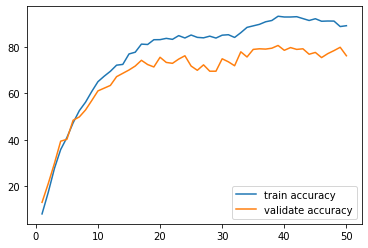

In [25]:
plt.figure(1)
plt.plot(x, train_acc, label='train accuracy')
plt.plot(x, validate_acc, label='validate accuracy')
plt.legend()
plt.show()

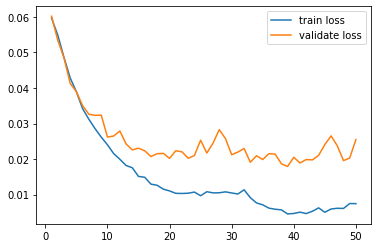

In [26]:
plt.figure(2)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, validate_loss, label='validate loss')
plt.legend()
plt.show()